# 🔍 Model Inferencing

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm

/media/ishfar/New Volume/Studies/Projects/Kaggle-Automated-Essay-Scoring/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("../../")

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.deberta import DeBERTA_V3
from lib.utils.utils import seed_everything
from lib.data_tools.data import collate, CustomDataset

In [4]:
seed_everything()

## 📖 Definitions

### 🌎 Global Variables

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 🛠️ Functions

In [6]:
def load_best_model_from_disk(config, device):
    model = DeBERTA_V3(
        config,
        config_path="output/microsoft/deberta-v3-base/config.pth",
        pretrained=False,
    )
    state = torch.load("output/microsoft/deberta-v3-base/microsoft_deberta-v3-base_fold_3_best.pth")

    model.load_state_dict(state["model"])
    model.to(device)
    return model

In [7]:
def inference_fn(test_df, tokenizer, device):
    # ======== DATASETS ==========
    test_dataset = CustomDataset(config, test_df, tokenizer, is_train=False)

    # ======== DATALOADERS ==========
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size_valid,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        drop_last=False,
    )

    # ======== MODEL ==========
    softmax = nn.Softmax(dim=1)

    model = load_best_model_from_disk(config, device)
    model.eval()  # set model in evaluation mode

    prediction_dict = {}
    preds = []
    idx = []

    with tqdm(test_loader, unit="test_batch", desc="Inference") as tqdm_test_loader:
        for _, batch in enumerate(tqdm_test_loader):
            inputs = collate(batch.pop("inputs"))
            ids = batch.pop("essay_ids")

            for k, v in inputs.items():
                inputs[k] = v.to(device)  # send inputs to device

            with torch.no_grad():
                y_preds = model(inputs)  # forward propagation pass
                _, y_preds = torch.max(softmax(torch.tensor(y_preds)), dim=1)

            preds.append(y_preds.to("cpu").numpy())  # save predictions
            idx.append(ids)

    prediction_dict["predictions"] = np.concatenate(preds)
    prediction_dict["essay_ids"] = np.concatenate(idx)

    return prediction_dict

## 💿 Loading from Disk

### 🪙 Tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained(Paths.TOKENIZER_PATH)
vocabulary = tokenizer.get_vocab()
total_tokens = len(vocabulary)
print("Total number of tokens in the tokenizer:", total_tokens)
print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of tokens in the tokenizer: 128003
DebertaV2TokenizerFast(name_or_path='output/microsoft/deberta-v3-base/tokenizer_v2', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=F

### 🗃️ Dataset

In [9]:
test_df = pd.read_csv(Paths.TEST_CSV_PATH)
test_df.shape

(3, 4)

100%|██████████| 3/3 [00:00<00:00, 567.69it/s]


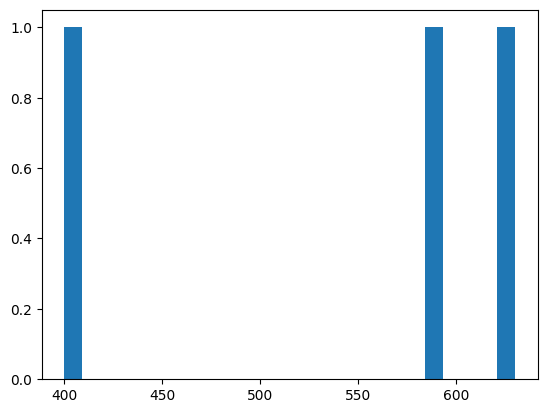

In [10]:
lengths = []
tqdm_loader = tqdm(test_df["full_text"].fillna("").values, total=len(test_df))
for text in tqdm_loader:
    length = len(tokenizer(text, add_special_tokens=False)["input_ids"])
    lengths.append(length)

# config.MAX_LEN = max(lengths) + 3 # cls & sep & sep
_ = plt.hist(lengths, bins=25)

## 🏁 Start Inferencing

In [11]:
predictions = inference_fn(test_df, tokenizer, device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Inference:   0%|          | 0/1 [00:00<?, ?test_batch/s]/tmp/ipykernel_9328/1166235807.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, y_preds = torch.max(softmax(torch.tensor(y_preds)), dim=1)
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.46test_batch/s]


## 💾 Saving submissions

In [12]:
submission = pd.DataFrame()
submission["essay_id"] = predictions["essay_ids"]
submission["score"] = predictions["predictions"]
submission["score"] = submission["score"] + 1 
print(f"Submission shape: {submission.shape}")
submission.to_csv("data/submission.csv", index=False)
submission

Submission shape: (3, 2)


,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,5
